# Set Up

In [37]:
!pip install geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Data Cleaning

In [38]:
# Load dataset (remember to upload dataset first)
hospital_df = pd.read_excel('/content/Hospital_General_Information_2016_2020.xlsx')

In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

In [40]:
# Basic info
hospital_df.info

<bound method DataFrame.info of       Facility ID  ...  Year
0          010001  ...  2020
1          010005  ...  2020
2          010006  ...  2020
3          010007  ...  2020
4          010008  ...  2020
...           ...  ...   ...
25077      670114  ...  2016
25078      640001  ...  2016
25079      650001  ...  2016
25080      650003  ...  2016
25081      660001  ...  2016

[25082 rows x 29 columns]>

In [41]:
# Number of NaN values in each column
hospital_df.isna().sum()

Facility ID                                                          0
Facility Name                                                        0
Address                                                              0
City                                                                 0
State                                                                0
ZIP Code                                                             0
County Name                                                         45
Phone Number                                                         0
Hospital Type                                                        0
Hospital Ownership                                                   0
Emergency Services                                                   0
Meets criteria for promoting interoperability of EHRs             3766
Hospital overall rating                                              0
Hospital overall rating footnote                                 17454
Mortal

In [42]:
# States of hospitals with NaN Counties
hospital_df[hospital_df['County Name'].isna()].State

10767    AK
10769    AK
10770    AK
10772    AK
10773    AK
10775    AK
10780    AK
10781    AK
15011    VI
15012    VI
15055    VA
15391    AS
15392    GU
15393    GU
15394    MP
16382    AK
16383    AK
16384    AK
16385    AK
16386    AK
16387    AK
16388    AK
16389    AK
20095    SD
20096    VI
20097    VI
20271    AS
20272    GU
20273    GU
20274    MP
21194    AK
21195    AK
21196    AK
21197    AK
21198    AK
21199    AK
21200    AK
21201    AK
24907    SD
24908    VI
24909    VI
25078    AS
25079    GU
25080    GU
25081    MP
Name: State, dtype: object

Only the columns containing "footnote" have a substantial number of `NaN` values, so those are the columns we'll drop. 

The column containing "EHR" consists of about 15% `NAN` values, so we'll encode the `NAN` values in that column as we would any other value. 

There are only 45 hospitals that have an NaN "County Name", so we'll just drop those rows.

In [43]:
# Drop footnote columns
hospital_df_cleaned = hospital_df.drop(labels=['Hospital overall rating footnote', 'Mortality national comparison footnote', 
                                               'Safety of care national comparison footnote', 'Readmission national comparison footnote', 
                                               'Patient experience national comparison footnote', 'Effectiveness of care national comparison footnote', 
                                               'Timeliness of care national comparison footnote', 'Efficient use of medical imaging national comparison footnote'], axis=1)

In [44]:
# Drop rows with NaN "County Name" values
hospital_df_cleaned.dropna(axis=0, subset=['County Name'], inplace=True)

In [45]:
# hospital_df_cleaned[hospital_df_cleaned['Hospital overall rating'] != 'Not Available']

Now we'll one-hot encode our categorical variables, remembering to replace the "NaN" values in the column containing "EHR" with a string. Note that we'll be treating the "Hospital overall rating" column as categorical, so as not to lose all of the rows with "Not Available" values, since lack of data may also be informative. We'll also change "Y" and "N" in the column containing "EHR" to "Yes" and "No" respectively, to match the "Emergeny Services" column.

In [46]:
# Replace NaN values in EHR column with string 'Not Available'
hospital_df_cleaned['Meets criteria for promoting interoperability of EHRs'].fillna('Not Available', inplace=True)

In [47]:
# Replace 'Y' with 'Yes' and 'N' with 'No' in EHR column
hospital_df_cleaned.replace(to_replace='Y', value='Yes', inplace=True)
hospital_df_cleaned.replace(to_replace='N', value='No', inplace=True)

We'll use the Pandas `get_dummies()` function, since it conveniently produces a one-hot-encoded dataframe with automatically generated column names. This is more expedient than using Scikit-learn's `OneHotEncoder`, which produces a matrix that we'd then have to convert to a dataframe after generating column labels for. Since we're currently only using this for EDA, we don't benefit from the major advantage that `OneHotEncoder` confers, which is that it can be used on later datasets with the same categorical variables. Even when we get to the machine learning portion of the analysis, we'll be splitting this dataset we're currently working with into a train and test set; thus, we don't need to preserve the encodings.

In [48]:
# Get only categorical columns in new dataframe
hospital_df_cleaned_categorical = hospital_df_cleaned.drop(labels=['Facility ID', 'Facility Name', 
                                                                   'Address', 'City', 'State', 
                                                                   'ZIP Code', 'County Name', 
                                                                   'Phone Number', 'Year'], axis=1)
# Convert all columns to type string
hospital_df_cleaned_categorical = hospital_df_cleaned_categorical.astype(str)

In [49]:
# oh_encoder = OneHotEncoder(handle_unknown='ignore')
# oh_encoder.fit(hospital_df_cleaned_categorical)

Note that we drop the first column of each feature's one hot encoding to avoid redundancy.

In [50]:
# One hot encode dataframe
hospital_df_encoded = pd.get_dummies(data=hospital_df_cleaned_categorical, drop_first=True)

In [51]:
hospital_df_encoded.head(10)

,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the National average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the National average,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the National average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the National average,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the National average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the National average,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the National average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the National average,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the National average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the National average,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the National average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the National average,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the National average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the National average,Efficient use of medical imaging national comparison_Same as the national average
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,

Let's now add the state and county (in title case) columns onto our cleaned, encoded data so that we can join it with the food and political datasets.

In [52]:
hospital_df_encoded['State'] = hospital_df_cleaned['State']

In [53]:
hospital_df_encoded['County'] = hospital_df_cleaned['County Name'].apply(lambda x: x.title())

In [54]:
hospital_df_encoded.head(10)

,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the National average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the National average,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the National average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the National average,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the National average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the National average,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the National average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the National average,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the National average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the National average,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the National average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the National average,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the National average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the National average,Efficient use of medical imaging national comparison_Same as the national average,State,County
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,AL,Houston
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,AL,Marshall
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,AL,Lauderdale
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,

In [55]:
# Drop duplicate columns with capitalized letter names that get_dummies
hospital_df_encoded.drop(['Mortality national comparison_Below the National average', 
                          "Mortality national comparison_Same as the National average",  
                          "Safety of care national comparison_Below the National average", 
                          "Safety of care national comparison_Same as the National average", 
                          "Readmission national comparison_Below the National average", 
                          "Readmission national comparison_Same as the National average", 
                          "Patient experience national comparison_Below the National average", 
                          "Patient experience national comparison_Same as the National average", 
                          "Effectiveness of care national comparison_Below the National average", 
                          "Effectiveness of care national comparison_Same as the National average", 
                          "Timeliness of care national comparison_Below the National average", 
                          "Timeliness of care national comparison_Same as the National average", 
                          "Efficient use of medical imaging national comparison_Below the National average", 
                          "Efficient use of medical imaging national comparison_Same as the National average"], axis=1)

,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the national average,State,County
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,AL,Houston
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,AL,Marshall
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,AL,Lauderdale
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,AL,Covington
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,AL,Crenshaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25073,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,TX,Burnet
25074,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,TX,Harris
25075,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,TX,Ector
25076,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,TX,Bexar


# PCA

Next, we'll perform a PCA.

In [56]:
# Instantiate PCA object
pca = PCA()

# Fit PCA object to dataset
pca.fit(hospital_df_encoded.drop(labels=['State', 'County'], axis=1))

# See percentage of total variance in data captured by each principal component
print(pca.explained_variance_ratio_)

[2.61734273e-01 8.60356503e-02 6.42395837e-02 4.60348408e-02
 4.19735782e-02 3.51021591e-02 3.07315427e-02 2.76263010e-02
 2.65211822e-02 2.56598389e-02 2.39412453e-02 2.23845576e-02
 2.08624874e-02 2.03841659e-02 1.77501324e-02 1.66973282e-02
 1.61206477e-02 1.42703970e-02 1.37394605e-02 1.33668511e-02
 1.21355612e-02 1.15131481e-02 1.08399387e-02 1.00441011e-02
 9.62372637e-03 9.20594022e-03 8.70696016e-03 8.58267207e-03
 8.32720321e-03 7.71816732e-03 6.38831440e-03 5.93673855e-03
 5.72048465e-03 5.49940098e-03 5.28088478e-03 4.87088249e-03
 4.53503544e-03 4.49699437e-03 4.14923123e-03 3.61855454e-03
 3.38485017e-03 3.08198241e-03 2.89184929e-03 2.83984709e-03
 2.18414668e-03 1.89183231e-03 1.79640563e-03 1.66035567e-03
 1.56443613e-03 1.36053139e-03 1.23678698e-03 1.05707885e-03
 6.37688722e-04 4.39610966e-04 3.30256488e-04 2.94027772e-04
 2.71665808e-04 2.38002186e-04 1.89952537e-04 1.27387290e-04
 8.47170472e-05 6.64262767e-05 2.24961013e-32]


Text(0.5, 1.0, 'Cumulative Explained Variance')

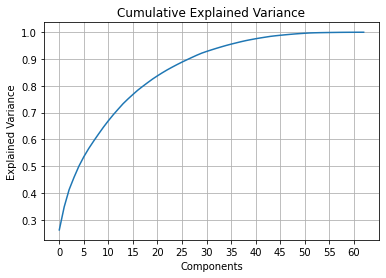

In [57]:
# Plot cumulative explained variance to find elbow
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xticks(np.arange(0, 63, step=5))
plt.xlabel("Components")
plt.ylabel("Explained Variance")
plt.title("Cumulative Explained Variance")

While there's no obvious elbow, the cumulative explained variance plot does suggest that we could try later analyses with a cutoff of around 30 components. It is immediately clear that we won't get anything useful out of a 2D or even 3D visualization from the first 2 or 3 components respectively, because they altogether capture less than 50% of the variance in the data. 

<!-- Let's try using t-SNE to visualize our data instead. -->

# Choropleth

We're now going to make a geographical map using the hospital data. We'll start by reading in a dataframe for US counties.

In [58]:
# Name file path
shapefile_path = '/content/cb_2020_us_county_500k.shx'

In [59]:
# Generate map dataframe
us_county_map_df = gpd.read_file(shapefile_path)

In [60]:
us_county_map_df

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,21,141,00516917,0500000US21141,21141,Logan,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
1,36,081,00974139,0500000US36081,36081,Queens,Queens County,NY,New York,06,281594050,188444349,"POLYGON ((-73.96262 40.73903, -73.96243 40.739..."
2,34,017,00882278,0500000US34017,34017,Hudson,Hudson County,NJ,New Jersey,06,119640822,41836491,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ..."
3,34,019,00882228,0500000US34019,34019,Hunterdon,Hunterdon County,NJ,New Jersey,06,1108086284,24761598,"POLYGON ((-75.19511 40.57969, -75.19466 40.581..."
4,21,147,00516926,0500000US21147,21147,McCreary,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,08,014,01945881,0500000US08014,08014,Broomfield,Broomfield County,CO,Colorado,06,85386686,1502572,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073..."
3230,08,121,00198176,0500000US08121,08121,Washington,Washington County,CO,Colorado,06,6521806795,15207397,"POLYGON ((-103.70655 39.73989, -103.70655 39.7..."
3231,27,037,00659464,0500000US27037,27037,Dakota,Dakota County,MN,Minnesota,06,1456967786,62978183,"POLYGON ((-93.32967 44.77948, -93.32962 44.791..."
3232,31,161,00835902,0500000US31161,31161,Sheridan,Sheridan County,NE,Nebraska,06,6321862270,74723228,"POLYGON ((-102.79287 42.82249, -102.79211 42.9..."


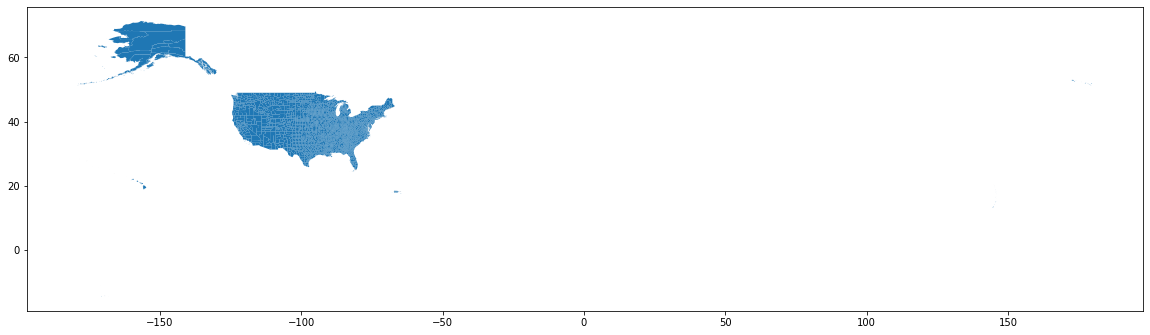

In [61]:
# Visualize US county map
us_county_map_df.plot(figsize=(20, 10))

As we can see, the shapefile includes counties in US territories like Puerto Rico and Guam. However, knowing that the political dataset that we'll be joining the hospital quality dataset to does not have data for the territories (since they don't participate in elections), we'll go ahead and remove these territories from `us_county_map_df` as well.

In [62]:
# Remove counties in territories
us_states_county_map_df = us_county_map_df.copy()
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Puerto Rico'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Guam'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'American Samoa'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Commonwealth of the Northern Mariana Islands'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'United States Virgin Islands'].index, inplace=True)

In [63]:
us_states_county_map_df[us_county_map_df['STATE_NAME'] == 'Alaska'].head(3)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
18,02,050,01419966,0500000US02050,02050,Bethel,Bethel Census Area,AK,Alaska,05,105223804364,12764675306,"MULTIPOLYGON (((-161.67073 58.56075, -161.6672..."
19,02,180,01419977,0500000US02180,02180,Nome,Nome Census Area,AK,Alaska,05,59490634310,13780758093,"MULTIPOLYGON (((-161.31946 64.12363, -161.3183..."
503,02,020,01416061,0500000US02020,02020,Anchorage,Anchorage Municipality,AK,Alaska,12,4420591349,621302197,"MULTIPOLYGON (((-150.07348 61.15834, -150.0691..."


(-200.0, -50.0)

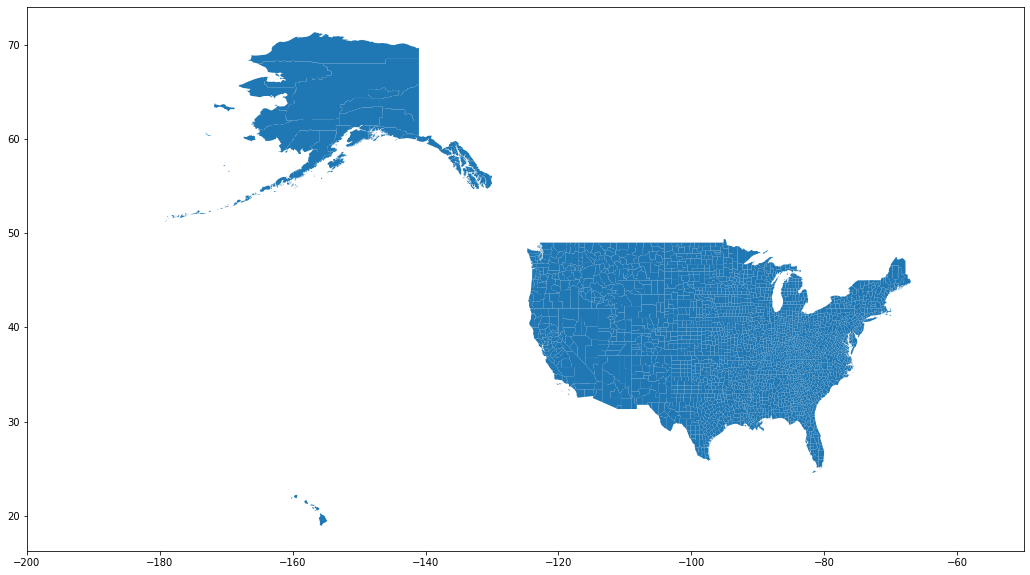

In [64]:
# Visualize US 50 states county map
us_states_county_map_df.plot(figsize=(20, 10))

# Cut off part of Alaska's Aleutian Islands for sake of reasonably sized and scaled visualization
plt.xlim([-200, -50])

Now we'll join this map data with some hospital data so that we can color-code the map accordingly.

In [65]:
# Join hospital_df_cleaned dataframe (with County Name in title case) and us_states_county_map_df dataframe
hospital_df_cleaned['County Name'] = hospital_df_cleaned['County Name'].apply(lambda x: x.title())
us_hospital_map_df = us_states_county_map_df.merge(right=hospital_df_cleaned[['State', 'County Name', 'Hospital overall rating']], how='right', left_on=['STUSPS', 'NAME'], right_on=['State', 'County Name'])

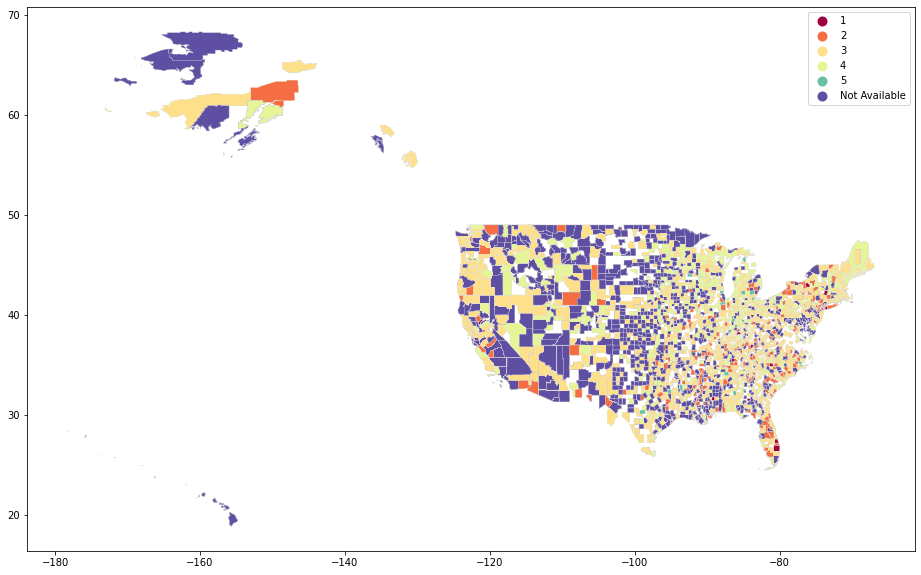

In [66]:
# Visualize merged dataframe, color-coded by 'Hospital overall rating'
fig, ax = plt.subplots(1, figsize=(20,10))
us_hospital_map_df.plot(column='Hospital overall rating', cmap='Spectral', linewidth=0.25, ax=ax, edgecolor='0.9', legend = True)

Hmm. What's probably happening here is that, because many counties have multiple hospitals, but we're not consolidating their reviews in any way, the only reviews we're seeing on the map are the last ones that appear in the dataset for their respective counties, since any previous ones are being overwritten.

To fix this, let's try dropping the "Not Available" rows out of the dataset and converting the 'Hospital overall rating' column to be of a numeric type, so that we can take the average over all hospitals recorded for each county.

In [67]:
# Get state, county, and rating columns from hospital dataset
hospital_df_cleaned_for_viz = hospital_df_cleaned[['State', 'County Name', 'Hospital overall rating']]

In [68]:
# Drop "Not Available" rows
hospital_df_cleaned_for_viz = hospital_df_cleaned_for_viz[hospital_df_cleaned_for_viz['Hospital overall rating'] != "Not Available"]

In [69]:
# Cast 'Hospital Overall Rating' column to be numeric
hospital_df_cleaned_for_viz['Hospital overall rating'] = pd.to_numeric(hospital_df_cleaned_for_viz['Hospital overall rating'])

In [70]:
# Get average hospital rating of each county
hospital_data_to_join = hospital_df_cleaned_for_viz.dropna().groupby(['State', 'County Name']).mean().reset_index()

In [71]:
# Join map dataset with average hospital rating dataset
us_average_hospital_map_df = us_states_county_map_df.merge(right=hospital_data_to_join, how='right', left_on=['STUSPS', 'NAME'], right_on=['State', 'County Name'])

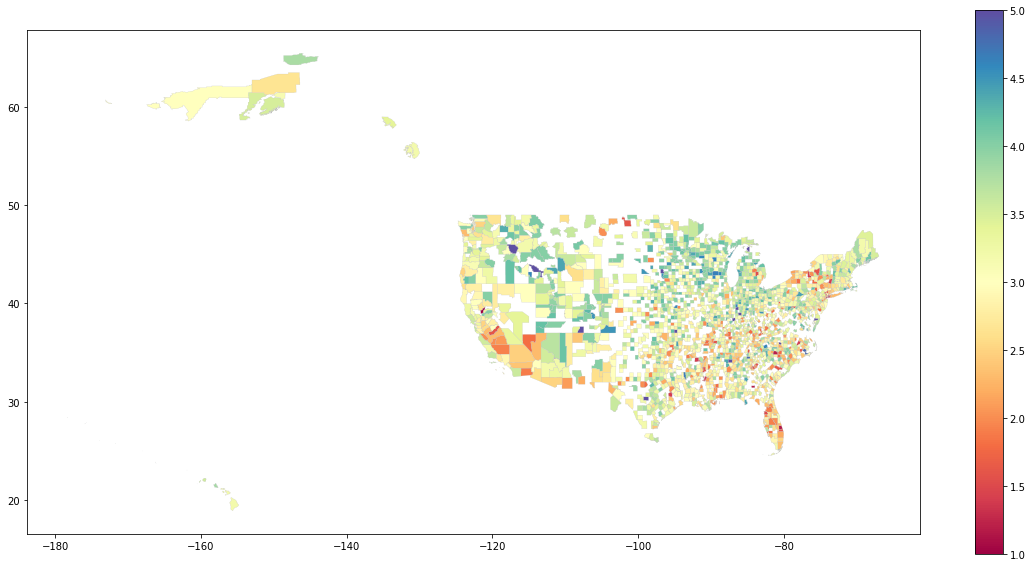

In [72]:
# Visualize merged dataframe, color-coded by 'Hospital overall rating'
fig, ax = plt.subplots(1, figsize=(20,10))
us_average_hospital_map_df.plot(column='Hospital overall rating', cmap='Spectral', linewidth=0.2, ax=ax, edgecolor='0.75', legend = True)

That makes much more sense!